# Statistics For Data Science - Final Project
Michael Ciniello
qq201128

# Introduction

**Credit Modeling:** 

For my final project, I will be creating a cedit model (a well known data science problem that focuses on modeling a borrower's credit risk). I'll be working with financial lending data from Lending Club. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. 

**The Data:**

Lending Club releases data for all of the approved and declined loan applications periodically on their website. I have used the the *approved loans dataset* which containing information on current loans, completed loans, and defaulted loans. The data also includes over 50 financial and non financial variables for each loan. 


**The Question:**

Can we build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not?

**Major Steps:**
- Step 1: Read in the Data
- Step 2: Explore Features
- Step 3: Target Column
- Step 4: More Data Cleansing
- Step 5: Dummy Variables
- Step 6: Select and Error Metric
- Step 7: Logistic Regression/Cross Validation
- Step 8: Penalizing the Classifier (Balanced Penalty)
- Step 9: Penalizing the Classifier (Custom Penalty)
- Conclusion

# Step 1: Read in the Data

Read in the data and perform initial data exploration to determine the size and shape of the data set. 

In [1]:
import pandas as pd

#Read in data, print shape
loans_2007 = pd.read_csv("loans_2007.csv")
print("DF SHAPE pre cleanse: ",loans_2007.shape, '\n')

#Drop columns with more than half of values missing
loans_2007.drop_duplicates()
half_count = len(loans_2007) / 2
loans_2007 = loans_2007.dropna(thresh=half_count, axis=1)
print("DF SHAPE post cleanse: ",loans_2007.shape, '\n')

C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


DF SHAPE pre cleanse:  (42538, 52) 

DF SHAPE post cleanse:  (42538, 52) 



# Step 2: Explore features

The next step is to delete any columns that would not be of any use to (or actually hinder) the analysis. These include any columns that:

- leak information from the future (after the loan has already been funded)
- don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club)
- are formatted poorly and need to be cleaned up
- require more data or a lot of processing to turn into a useful feature
- contain redundant information

In [2]:
#Review column descriptions to understand feature
file = pd.ExcelFile('col_descrip.xlsx')
col_descrip = file.parse('Sheet1')
col_descrip.iloc[0:5,]

first=[]
second=[]
third=[]
dtype=[]
for col in loans_2007.columns:
    first.append(loans_2007[col][0])
    second.append(loans_2007[col][1])
    third.append(loans_2007[col][2])
    dtype.append(type(loans_2007[col][0]))

first_rows = pd.DataFrame({'Columns':loans_2007.columns,'type':dtype,'first':first,'second':second,'third':third})
col_descrip = pd.merge(col_descrip,first_rows, on='Columns')

#print column names and descriptions for review
col_descrip

,Columns,Description,first,second,third,type
0,acc_now_delinq,The number of accounts on which the borrower i...,0,0,0,<class 'numpy.float64'>
1,addr_state,The state provided by the borrower in the loan...,AZ,GA,IL,<class 'str'>
2,annual_inc,The self-reported annual income provided by th...,24000,30000,12252,<class 'numpy.float64'>
3,application_type,Indicates whether the loan is an individual ap...,INDIVIDUAL,INDIVIDUAL,INDIVIDUAL,<class 'str'>
4,chargeoff_within_12_mths,Number of charge-offs within 12 months,0,0,0,<class 'numpy.float64'>
5,collection_recovery_fee,post charge off collection fee,0,1.11,0,<class 'numpy.float64'>
6,collections_12_mths_ex_med,Number of collections in 12 months excluding m...,0,0,0,<class 'numpy.float64'>
7,delinq_2yrs,The number of 30+ days past-due incidences of ...,0,0,0,<class 'numpy.float64'>
8,delinq_amnt,The past-due amount owed for the accounts on w...,0,0,0,<class 'numpy.float64'>
9,dti,A ratio calculated using the borrower’s total ...,27.65,1,8.72,<class 'numpy.float64'>


After reviewing all of the columns and their contents, the following columns are required to be deleted:

- **id:** randomly generated field by Lending Club for unique identification purposes only
- **member_id:** also a randomly generated field by Lending Club for unique identification purposes only
- **funded_amnt:** leaks data from the future (after the loan is already started to be funded)
- **funded_amnt_inv:** also leaks data from the future (after the loan is already started to be funded)
- **grade:** contains redundant information as the interest rate column (int_rate)
- **sub_grade:** also contains redundant information as the interest rate column (int_rate)
- **emp_title:** requires other data and a lot of processing to potentially be useful
- **issue_d:** leaks data from the future (after the loan is already completed funded) 
- **zip_code:** redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)
- **out_prncp:** leaks data from the future, (after the loan already started to be paid off)
- **out_prncp_inv:** also leaks data from the future, (after the loan already started to be paid off)
- **total_pymnt:** also leaks data from the future, (after the loan already started to be paid off)
- **total_pymnt_inv:** also leaks data from the future, (after the loan already started to be paid off)
- **total_rec_prncp:** also leaks data from the future, (after the loan already started to be paid off)
- **total_rec_int:** leaks data from the future, (after the loan already started to be paid off),
- **total_rec_late_fee:** also leaks data from the future, (after the loan already started to be paid off),
- **recoveries:** also leaks data from the future, (after the loan already started to be paid off),
- **collection_recovery_fee:** also leaks data from the future, (after the loan already started to be paid off),
- **last_pymnt_d:** also leaks data from the future, (after the loan already started to be paid off),
- **last_pymnt_amnt:** also leaks data from the future, (after the loan already started to be paid off).

In [3]:
#Remove columns not useful for our analysis
drop_cols = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "grade", "sub_grade", "emp_title", "issue_d",
             "zip_code", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp",
             "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"]
             

print("DF SHAPE pre cleanse: ",loans_2007.shape, '\n')
loans_2007 = loans_2007.drop(drop_cols, axis=1)
print("DF SHAPE post cleanse: ",loans_2007.shape, '\n')

DF SHAPE pre cleanse:  (42538, 52) 

DF SHAPE post cleanse:  (42538, 32) 



# Step 3: Target Column Cleansing

**Overview:** The next step is to clean the 'target column', which is the column we want to predict (otherwise known as the dependent variable). In this case, as the goal here is to predict whether a loan will default or not, the target column is 'loan_status':

**The 'loan_status' column:** directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. There are 8 different possible values for the loan_status column. 

**The investor's perspective:** We're interested in trying to predict which loans will be paid off on time and which ones won't be. Only the Fully Paid and Charged Off values describe the final outcome of the loan, so we need to do two things:

- Remove all the loans that don't contain either Fully Paid and Charged Off as the loan's status
- transform the Fully Paid values to 1 for the positive case and the Charged Off values to 0 for the negative case.

In [4]:
#Print unique values in target column (loan_status), and proportion % of each
target = loans_2007['loan_status'].value_counts(dropna=False)

percent_total = []
for i in range(0,10):
    percent_total.append(target[i]/loans_2007.shape[0])

pd.DataFrame({'Result of Loan':target.index,'Number of Obs':target.values, 'Percent Total':percent_total})

,Number of Obs,Percent Total,Result of Loan
0,33136,0.778974,Fully Paid
1,5634,0.132446,Charged Off
2,1988,0.046735,Does not meet the credit policy. Status:Fully ...
3,961,0.022592,Current
4,761,0.017890,Does not meet the credit policy. Status:Charge...
5,24,0.000564,Late (31-120 days)
6,20,0.000470,In Grace Period
7,8,0.000188,Late (16-30 days)
8,3,0.000071,Default
9,3,0.000071,NaN


In [5]:
#Select only rows in target column with 'Full Paid' or 'Charged Off' values, replace with 1 and 0
#select only rows with 'Fully Paid' or 'Charged Off' in loan_status column
print("DF SHAPE pre cleanse: ",loans_2007.shape, '\n')
loans_2007 = loans_2007[(loans_2007['loan_status'] == "Fully Paid") | (loans_2007['loan_status'] == "Charged Off")]

#map replace binary data (1,0)
status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}

loans_2007 = loans_2007.replace(status_replace)

#print sample of new loan_status column
print("DF SHAPE post cleanse: ",loans_2007.shape, '\n')
print(loans_2007['loan_status'].head())

DF SHAPE pre cleanse:  (42538, 32) 

DF SHAPE post cleanse:  (38770, 32) 

0    1
1    0
2    1
3    1
5    1
Name: loan_status, dtype: int64


# Step 4: More Data Cleansing
Over 80% of data modeling is often data cleansing. Below is the last of the data cleansing process before we can start modeling!

In [6]:
#Drop columns that only have only one unique value
print("DF SHAPE pre cleanse: ",loans_2007.shape, '\n')
orig_columns = loans_2007.columns
drop_columns = []
for col in orig_columns:
    col_series = loans_2007[col].dropna().unique()
    if len(col_series) == 1:
        drop_columns.append(col)
loans = loans_2007.drop(drop_columns, axis=1)
print("Dropped columns: ", drop_columns, '\n')
print("DF SHAPE post cleanse: ",loans.shape, '\n')

DF SHAPE pre cleanse:  (38770, 32) 

Dropped columns:  ['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'] 

DF SHAPE post cleanse:  (38770, 23) 



In [7]:
#Handling missing values
# 1. remove columns entirely where more than 1% of the rows for that column contain a null value.
# 2. remove the remaining rows containing null values.

#create missing value count
null_counts = loans.isnull().sum()
print(null_counts)

loan_amnt                 0
term                      0
int_rate                  0
installment               0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
title                    10
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               50
total_acc                 0
last_credit_pull_d        2
pub_rec_bankruptcies    697
dtype: int64


In [8]:
#remove 'pub_rec_bankruptcies'
print("DF SHAPE post cleanse: ",loans.shape, '\n')
loans = loans.drop("pub_rec_bankruptcies", axis=1)
loans = loans.dropna(axis=0)
print("DF SHAPE post cleanse: ",loans.shape, '\n')

DF SHAPE post cleanse:  (38770, 23) 

DF SHAPE post cleanse:  (38708, 22) 



In [9]:
#Converting values to numeric
# 1. identify columns with non-numeric types
# 2. delete columns that can't or shouldn't be converted to either numeric or dummy vars.
# 3. transorm remaining columns to either numeric or categorical dummy variables

#how many object columns are there?
print(loans.dtypes.value_counts())

object     11
float64    10
int64       1
dtype: int64


In [10]:
#isolate object type columns, and select sample rows
object_columns_df = loans.select_dtypes(include=["object"])
print(object_columns_df.iloc[1])

term                         60 months
int_rate                        15.27%
emp_length                    < 1 year
home_ownership                    RENT
verification_status    Source Verified
purpose                            car
title                             bike
addr_state                          GA
earliest_cr_line              Apr-1999
revol_util                        9.4%
last_credit_pull_d            Sep-2013
Name: 1, dtype: object


In [11]:
#create emp_length mapping dict
mapping_dict = {"emp_length": 
        {"10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0}}
loans = loans.replace(mapping_dict)

#drop date columns (requires too much feature engineering for now...) and addr_state (it would require 49 dummy variabbles)
loans = loans.drop(["last_credit_pull_d", "earliest_cr_line", "addr_state", "title"], axis=1)

#convert int_rate and revol_util column to numeric
loans["int_rate"] = loans["int_rate"].str.rstrip("%").astype("float")
loans["revol_util"] = loans["revol_util"].str.rstrip("%").astype("float")

# Step 5: Dummy variables

Some of our variables are NOT numerical. As such, we need to create dummy variables for each option. This is essentially a method for turning non-numeric values into numeric values that can be plugged into a machine learning model. 

In [12]:
#define categorical variable columns
cat_columns = ["home_ownership", "verification_status", "purpose", "term"]

#create dummy variables
dummy_df = pd.get_dummies(loans[cat_columns])

#concat dummy_df and loans. Drop original categorical columns. print loans df columns
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(cat_columns, axis=1)
print(loans.columns, '\n')

print("DF SHAPE post cleanse: ",loans.shape)

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object') 

DF SHAPE post cleanse:  (38708, 38)


In [13]:
loans.shape

(38708, 38)

# Step 6: Select an Error Metric

Now that the data cleansing is complete, the next step in the process is to select an error metric. This is essentially a method for us to judge our model's predictive effectiveness. The general approach is to keep tweaking the model until it spits out an error metric that we are satisfied with. There are several considerations we need to keep in mind before making our selection:

**Conservative investor vantage point:** We need to treat false positives (loans that the model predicts will be paid off but actually default) differently than false negatives (loans that the model predicts will NOT be paid off but actually are). A conservative investor would want to minimize risk, and avoid false positives as much as possible. They'd be more okay with missing out on opportunities (false negatives) than they would be with funding a risky loan (false positives).

**Class Imbalance**: However, there are about 6 times as many loans that were paid off on time (positive case, label of 1) than those that weren't (negative case, label of 0). Imbalances can cause issues with many machine learning algorithms, where they appear to have high accuracy, but actually aren't learning from the training data. In this case, we don't want to use accuracy, and should instead use metrics that tell us the number of false positives and false negatives.

This means that we should optimize for:

- high recall (true positive rate)
- low fall-out (false positive rate)

In [14]:
#Create Error Metric filters function
import pandas as pd
import numpy

#create fpr,tpr formula
def fpr_tpr(preds,target):
    # False positives.
    fp_filter = (preds == 1) & (target == 0)
    fp = len(preds[fp_filter])

    # True positives.
    tp_filter = (preds == 1) & (target == 1)
    tp = len(preds[tp_filter])

    # False negatives.
    fn_filter = (preds == 0) & (target == 1)
    fn = len(preds[fn_filter])

    # True negatives
    tn_filter = (preds == 0) & (target == 0)
    tn = len(preds[tn_filter])

    # Rates
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr,fpr

# Step 7: Logistic Regression / Cross Validation

Now that we have a clean data set, as well as a chosen error metric, we can start modeling! We will use the 37 independent variable columns (called features) to train our model to predict the outcome of the dependent variable (in this case it is loan status). The dependent variable is binary, either a 1 (loan paid back) or 0 (loan defaulted). For this type of model, we use a logistic regression.

In [15]:
import pandas as pd

#Read in cleaned data, print shape
loans2 = pd.read_csv("cleaned_loans_2007.csv")
loans2.shape

(38708, 38)

True Positive Rate:  0.9985092241754147
False Positive Rate:  0.9987125252896818


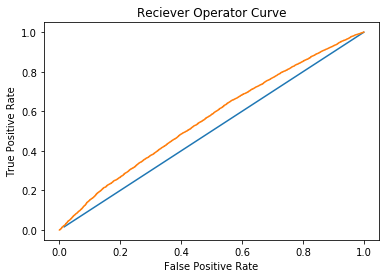

AUC Score:  0.561003851124


(0.9985092241754147, 0.9987125252896818)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

#initialize
lr = LogisticRegression()
cols = loans.columns
train_cols = cols.drop("loan_status")
features = loans[train_cols]
target = loans["loan_status"]

#train model
kf = KFold(features.shape[0],n_folds=3,random_state=1)
predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

#Use tpr/fpr function
tpr1, fpr1 = fpr_tpr(predictions,loans["loan_status"])

#plot the ROC
probs = cross_val_predict(lr, features, target, cv=kf, method='predict_proba')
falp,trup,thresholds = metrics.roc_curve(target,probs[:,1])
y=list(range(1,65))
rand=[x*(1/64) for x in y]
plt.plot(rand,rand)
plt.plot(falp,trup)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Reciever Operator Curve')

print('True Positive Rate: ',tpr1)
print('False Positive Rate: ',fpr1)

plt.show()

from sklearn.metrics import roc_auc_score
auc_score = metrics.roc_auc_score(target,probs[:,1])
print("AUC Score: ", auc_score)

fpr_tpr(predictions,loans["loan_status"])

Above is an example of a Receiver Operator Curve for our first model. It represents the tradeoff between the True Positive rate and the False Positive rate. Intuitively, if the model assumed that ALL outcomes will be one, then the True Positive rate will be 100% (as it correctly predicted all of the 1s), however the False positive rate will also be 100% (it also incorrectly identified all of the 0s.) The higher the TPR, and the lower the FPR, the better the model, and the larger the area under the curve (AUC). As we can see from the above ROC, our model has a AUC of about 56%... which is just above random, not very good!

In [17]:
features

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.00,27.65,0.0,1.0,3.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2500.0,15.27,59.83,0,30000.00,1.00,0.0,5.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2400.0,15.96,84.33,10,12252.00,8.72,0.0,2.0,2.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,10000.0,13.49,339.31,10,49200.00,20.00,0.0,1.0,10.0,0.0,...,0,0,0,1,0,0,0,0,1,0
5,5000.0,7.90,156.46,3,36000.00,11.20,0.0,3.0,9.0,0.0,...,0,0,0,0,0,0,0,1,1,0
6,7000.0,15.96,170.08,8,47004.00,23.51,0.0,1.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7,3000.0,18.64,109.43,9,48000.00,5.35,0.0,2.0,4.0,0.0,...,0,0,0,0,0,0,0,0,1,0
8,5600.0,21.28,152.39,4,40000.00,5.55,0.0,2.0,11.0,0.0,...,0,0,0,0,0,1,0,0,0,1
9,5375.0,12.69,121.45,0,15000.00,18.08,0.0,0.0,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1
10,6500.0,14.65,153.45,5,72000.00,16.12,0.0,2.0,14.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Import EarlyStopping
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


# Save the number of columns in predictors: n_cols
n_cols = predictors.shape[1]
input_shape = (n_cols,)

# Specify the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = input_shape))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model, SET THE CALLBACKS ARG AS EARLY STOPPING AND SET EPOCHS TO 30
model.fit(predictors, target, epochs=30, validation_split=0.30, callbacks=[early_stopping_monitor])


# Step 8: Penalizing The Classifier (Balanced Penalties)
**High TPR, but also high FPR:** In our first model, our fpr and tpr are around what we'd expect if the model was predicting all ones, this is the 'class imbalance' coming into effect... and it is seriously skewing our model!

**Using 'class_weight=balanced' arg:** To address this issue, we will tell the classifier to penalize misclassifications of the less prevalent class more than the other class. We can do this by setting the class_weight parameter to balanced when creating the LogisticRegression instance. This tells scikit-learn to penalize the misclassification of the minority class during the training process. The penalty means that the logistic regression classifier pays more attention to correctly classifying rows where loan_status is 0. **In non-technical terms, the punishment for misclassfying a 0 becomes higher than the punishment for misclassying a 1. This lowers accuracy when loan_status is 1, but raises accuracy when loan_status is 0.**

By setting the class_weight parameter to balanced, the penalty is set to be inversely proportional to the class frequencies. This would mean that for the classifier, correctly classifying a row where loan_status is 0 is 6 times more important than correctly classifying a row where loan_status is 1.

True Positive Rate:  0.6737074305744417
False Positive Rate:  0.3923419412288513


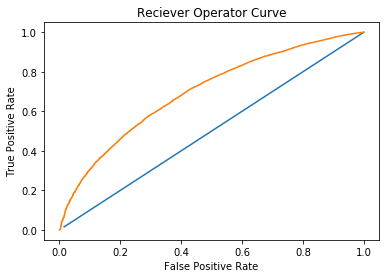

AUC Score:  0.696515653463


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import cross_val_predict

lr = LogisticRegression(class_weight="balanced")
kf = KFold(features.shape[0], random_state=1)
predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

#Use tpr/fpr function
tpr2, fpr2 = fpr_tpr(predictions,loans["loan_status"])

# plot the ROC
probs = cross_val_predict(lr, features, target, cv=kf, method='predict_proba')
fal_p,tru_p,thresholds = metrics.roc_curve(target,probs[:,1])
y=list(range(1,65))
rand=[x*(1/64) for x in y]
plt.plot(rand,rand)
plt.plot(fal_p,tru_p)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Reciever Operator Curve')

print('True Positive Rate: ',tpr2)
print('False Positive Rate: ',fpr2)

plt.show()

from sklearn.metrics import roc_auc_score
auc_score = metrics.roc_auc_score(target,probs[:,1])
print("AUC Score: ", auc_score)

# Step 9: Penalizing The Classifier (Manual Penalties)

We significantly improved false positive rate in the second model by balancing the classes, which reduced the true positive rate. Our true positive rate is now around 67%, and our false positive rate is around 40%. **From a conservative investor's standpoint, it's reassuring that the false positive rate is lower because it means that we'll be able to do a better job at avoiding bad loans than if we funded everything. However, we'd only ever decide to fund 67% of the total loans (true positive rate), so we'd immediately reject a good amount of loans.**

We can try to lower the false positive rate further by assigning a harsher penalty for misclassifying the negative class. While setting class_weight to balanced will automatically set a penalty based on the number of 1s and 0s in the column, we can also set a manual penalty. In the last screen, the penalty scikit-learn imposed for misclassifying a 0 would have been around 5.89 (since there are 5.89 times as many 1s as 0s).

True Positive Rate:  0.23965793370199137
False Positive Rate:  0.09225289403383793


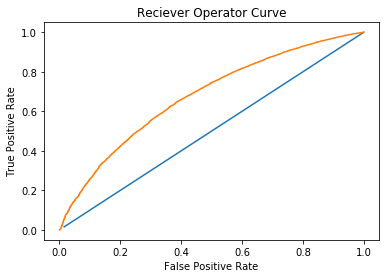

AUC Score:  0.675619745525


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import cross_val_predict

#set the penalty to 10x!
custom_penalty = {
    0: 10,
    1: 1
}

lr = LogisticRegression(class_weight=custom_penalty)
kf = KFold(features.shape[0], random_state=1)
predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

#Use tpr/fpr function
tpr3, fpr3 = fpr_tpr(predictions,loans["loan_status"])

# plot the ROC
probs = cross_val_predict(lr, features, target, cv=kf, method='predict_proba')
fal_p,tru_p,thresholds = metrics.roc_curve(target,probs[:,1])
y=list(range(1,65))
rand=[x*(1/64) for x in y]
plt.plot(rand,rand)
plt.plot(fal_p,tru_p)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Reciever Operator Curve')

print('True Positive Rate: ',tpr3)
print('False Positive Rate: ',fpr3)

plt.show()

from sklearn.metrics import roc_auc_score
auc_score = metrics.roc_auc_score(target,probs[:,1])
print("AUC Score: ", auc_score)

# Conclusion

Model 1: Logistic regression with cross validation
- Our first model was super effective at predicting 1s (loans that would be paid off) with a 99.8% TPR. However this is largely due to the class imbalance (there are far more 1s than 0s in the data, so the model just classified pretty much everything as a 1). Indeed, this model also produced a False Positive Rate of 99%, which would result in a lot of risky loans being funded. 

Model 2: Logistic Regression with balanced weighting of classes
- This model was better, as it has a lower FPR of 39%, but a lower TPR of 67%. However, this is an overall improvement from the previous model. 

Model 3: Logistic Regression with 10:1 weighting of classes
- Model three lowers the FPR to 9%. This means that we reject almost all of the loans that have an actual classification of 0. This is good for deterring lending to risky borrowers, however in this model we would also be rejecting a lot of good loans (the TPR is only 23%)

Overall, Model 2 appears to be the best, as it seems to be in the middle ground between the TPR and FPR tradeoff. However each model may be better suited for different situations depending upon the aggressiveness of the investor.

In [18]:
pd.DataFrame({"Model 1":[tpr1,fpr1],"Model 2":[tpr2,fpr2],"Model 3":[tpr3,fpr3]},index=['True Pos. Rate','False Pos. Rate'])

,Model 1,Model 2,Model 3
True Pos. Rate,0.998852,0.673707,0.239658
False Pos. Rate,0.996972,0.392342,0.092253
